# Intro

The initial dataset being sourced is from the HuggingFace library, (https://huggingface.co/datasets/brianarbuckle/cocktail_recipes)

This initial dataset contains columns `title`, `ingredients`, `directions`, `misc`, `source`, and `ner`.

**Overview**
The 'Ingredients' column of our dataset presents a unique challenge. It consists of objects, each being a list of strings, where each string details a part of a cocktail recipe. These details typically include the quantity, unit, and name of an ingredient, but they can also contain preparation instructions or garnishing details that are not directly usable in their current form for data analysis or recipe generation.

**Objective**
Our goal is to parse these strings to extract structured information that can be effectively utilized in our project. Specifically, we aim to separate the ingredient details into distinct components: quantity, unit, and ingredient name, while filtering out the non-ingredient related information.

## Imports

In [38]:
import pandas as pd
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

## Initial Data Inspection

In [39]:
# Loading the cocktail_recipes dataset
dataset = load_dataset('brianarbuckle/cocktail_recipes')

df = pd.DataFrame(dataset['train'])

In [40]:
df.head(5)

,title,ingredients,directions,misc,source,ner
0,151 Swizzle,[1.5 oz. 151-Proof Demerara Rum [Lemon Hart or...,[],[],Beachbum Berry Remixed,"[pernod, rum]"
1,20th Century,"[The 21st Century, 2 oz. Siete Leguas Blanco T...","[shake on ice and strain into coupe , The Best...",[],Jim Meehan,"[cocchi americano, pernod, tequila]"
2,20th Century,"[1.5 oz. Plymouth Gin, 3\/4 oz. Mari Brizard W...",[shake on ice and strain],[],PDT,"[lillet, gin]"
3,Abbey Cocktail,[],"[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,[]
4,Absinthe Drip,[1 1/2 ounces Pernod (or other absinthe substi...,[Pour Pernod into a pousse-caf or sour glass....,[The Absinthe Drip was made famous by Toulouse...,The Ultimate Bar Book,"[pernod, absinthe]"


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        875 non-null    object
 1   ingredients  875 non-null    object
 2   directions   875 non-null    object
 3   misc         875 non-null    object
 4   source       875 non-null    object
 5   ner          875 non-null    object
dtypes: object(6)
memory usage: 41.1+ KB


In [42]:
df.shape

(875, 6)

# Data Cleaning

## Lowercase standardization

Here we remove adjectives and lowercase all ingredients to avoid redundancies. 

In [43]:
def lowercase_ingredients(ingredients_list):
    """
    Converts all strings within a list of ingredients to lowercase.

    This function is useful for standardizing the case of all ingredient entries,
    making the dataset more uniform for analysis or processing.

    Parameters:
    
    ingredients_list (list): A list of ingredient strings.
      Returns:
    A list of ingredients with all strings converted to lowercase.
    """
    # Check if ingredients_list is indeed a list; if not, return it as is
    if not isinstance(ingredients_list, list):
        return ingredients_list

    # Convert each ingredient in the list to lowercase
    lowercase_list = [ingredient.lower() for ingredient in ingredients_list]
    return lowercase_list

# Apply the function to the 'ingredients' column
df['ingredients'] = df['ingredients'].apply(lowercase_ingredients)

## Adjective Removal

To eliminate ingredient redundancies, we are removing adjectives in the following code block:

In [44]:
# Lowercase all items in the ingredient list and remove "fresh"
for index, row in df.iterrows():
    # Update the ingredients list by removing 'fresh' if it exists
    updated_ingredients = [ingredient.replace('fresh ', '') if 'fresh ' in ingredient else ingredient for ingredient in row['ingredients']]
    # Update the DataFrame with the modified ingredients list
    df.at[index, 'ingredients'] = updated_ingredients

## Deleting Empty Rows

### Filtering rows where `Ingredients` is empty

There were two scenarios in the data, ingredients being len of 0, and ingredients being an empty string list (len of 1, being the list, but its still empty).

In [45]:
# Filter rows where `ingredients` is not empty and not just an empty string list
modified_df = df[df['ingredients'].apply(lambda x: len(x) > 0 and x != [''])].reset_index(drop=True)

## Normalization

### Ingredients Lists: Separating Combined Strings

In [46]:
def split_combined_ingredients(ingredients_list):
    """
    Splits a single-item list containing a string of ingredients separated by commas
    into a list of individual ingredients. If the list contains more than one item or
    if the single item does not contain a comma, the original list is returned.

    This is useful for normalizing ingredients lists where all ingredients are combined
    into a single string.

    Parameters:
    - ingredients_list: A list of ingredient(s).

    Returns:
    - A list of separated and trimmed ingredient strings.
    """
    if len(ingredients_list) == 1 and ',' in ingredients_list[0]:
        return [ingredient.strip() for ingredient in ingredients_list[0].split(', ')]
    else:
        return ingredients_list

# Applying the function
modified_df['ingredients'] = modified_df['ingredients'].apply(split_combined_ingredients)

### Deleting ingredients listed as optional 

In [47]:
def filter_optional_ingredients(ingredients_list):
    """
    Filters out ingredients marked as "optional" from a list of ingredients.
    
    This function iterates through a given list of ingredient strings, removing
    any ingredient that contains the word "optional". The goal is to create a more
    concise and essential list of ingredients by excluding those that are not
    crucial to the recipe. This step is part of data cleaning to standardize
    the ingredients data for further analysis.
    
    Parameters:
    - ingredients_list: A list of strings, where each string is an ingredient.

    Returns:
    - A list of ingredient strings, excluding any marked as "optional".
    """
    optional_keyword = 'optional'
    filtered_list = [ingredient for ingredient in ingredients_list if optional_keyword not in ingredient.lower()]
    return filtered_list

# Apply the filtering function to the 'ingredients' column
modified_df['ingredients'] = modified_df['ingredients'].apply(filter_optional_ingredients)


### Deleting steps in `ingredients` that are not usable

In [48]:
def delete_row_at(df, row_index):
    """
    Removes a specified row from the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - row_index (int): The index of the row to remove.

    Returns:
    - None; modifies the DataFrame in place.
    """
    # Ensure the row_index is within the DataFrame's range
    if row_index < 0 or row_index >= 871:
        print(f"Delete_row; Row index is out of DataFrame's range. Row = {row_index}")
        return
    
    # Drop the specified row without resetting the index
    df.drop(index=row_index, inplace=True)

In [49]:
def delete_ingredients_at_steps(df, row_index, ingredient_steps):
    """
    Removes ingredients at specified steps (indices) from the list of ingredients
    for a given row in the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the recipe information.
    - row_index (int): The index of the row from which to remove the ingredients.
    - ingredient_steps (list of int): The indices of the ingredients to remove within the ingredients list.
    
    Returns:
    - None; modifies the DataFrame in place.
    """
    # Ensure the row_index is within the DataFrame's range
    if row_index < 0 or row_index >= 871:
        print(f"Delete_ingredients: Row index is out of DataFrame's range. Row = {row_index}")
        return
    
    # Get the current list of ingredients for the specified row
    ingredients_list = df.at[row_index, 'ingredients']
    
    # Check if ingredient_steps is a single integer, wrap it in a list
    if isinstance(ingredient_steps, int):
        ingredient_steps = [ingredient_steps]

    # Ensure ingredients_list is a list
    if not isinstance(ingredients_list, list):
        print("Ingredients are not in list format for the specified row.")
        return
    
    # Remove the ingredients at the specified steps
    # Sort the indices in reverse order to avoid index shift during deletion
    for step in sorted(ingredient_steps, reverse=True):
        # Check each step's validity before attempting to delete
        if step < 0 or step >= len(ingredients_list):
            print(f"Ingredient step {step} is out of range and will not be deleted.")
            continue
        del ingredients_list[step]
    
    # Update the DataFrame in place
    df.at[row_index, 'ingredients'] = ingredients_list

We will be utilizing these two functions in order to delete entries in `ingredients`, or entire rows of the `modified_df` 

In [50]:
i = 825 # Put in starting index for session

In [51]:
# Use this to check row [n] of modified_df['ingredients']
print(f"Index {i}")
ingredients = modified_df['ingredients'][i]
print(ingredients)


# Display the function calls with the dynamic length of the ingredients list
print(f"\n\ndelete_ingredients_at_steps(modified_df, {i}, [0]) #") 
print(f"\ndelete_ingredients_at_steps(modified_df, {i}, [{len(ingredients)-1}]) #") # Assuming you want to pass the length directly
print(f"\ndelete_row_at(modified_df, {i}) #")

i += 1

Index 825
['these are the classic proportions for a vodka martini;', '2 ounces vodka', '1/2 ounce dry vermouth', 'lemon twist (or green cocktail olive)']


delete_ingredients_at_steps(modified_df, 825, [0]) #

delete_ingredients_at_steps(modified_df, 825, [3]) #

delete_row_at(modified_df, 825) #


In [52]:
# Got these working
delete_ingredients_at_steps(modified_df, 0, [6, 7])
delete_ingredients_at_steps(modified_df, 1, [0,4])
delete_ingredients_at_steps(modified_df, 5, [6,7])
delete_ingredients_at_steps(modified_df, 6, [7])
delete_row_at(modified_df, 7)
delete_row_at(modified_df, 8)
delete_row_at(modified_df, 10)

delete_row_at(modified_df, 13)
delete_ingredients_at_steps(modified_df, 15, [3,4,5,6,7,8,9,10,11]) # commentary steps
delete_row_at(modified_df, 16) # recipie is in parts (3/4 dry gin, 1/4 yellow chartreuse)
delete_row_at(modified_df, 17) # odd steps, seems like steps w/o ingredients

delete_ingredients_at_steps(modified_df, 20, [3]) # 'shake on ice'
delete_ingredients_at_steps(modified_df, 21, [3]) # 'From'
delete_ingredients_at_steps(modified_df, 22, [3,4]) # Shake on ice and strain, garnish with pineapple leaf

delete_ingredients_at_steps(modified_df, 33, [3,4])
delete_row_at(modified_df, 34)
delete_ingredients_at_steps(modified_df, 36, [4])
delete_ingredients_at_steps(modified_df, 37, [4])

delete_row_at(modified_df,41) # substitute x ingredient with y
# delete_ingredients_at_steps(modified_df, 43, [7,8]) # lime wedge and avocado slice

delete_row_at(modified_df,51) # Not enough information
delete_ingredients_at_steps(modified_df,53,[4])
# row 57 is a bit weird, it has both fractions and ounces. We can keep it if it parses properly

delete_row_at(modified_df, 61) # parts
delete_ingredients_at_steps(modified_df, 64, [0]) #name
delete_row_at(modified_df, 65) #no ingredients
delete_ingredients_at_steps(modified_df, 66, [0]) #name
delete_row_at(modified_df, 68) #no ingredients

delete_row_at(modified_df, 71) # fraction

delete_row_at(modified_df, 80) # fraction
delete_ingredients_at_steps(modified_df, 82, [0]) # cocktail introduction
delete_ingredients_at_steps(modified_df, 84, [2]) # Descriptive step
delete_row_at(modified_df, 86) # x but with y 

delete_row_at(modified_df, 90) # x but with y 
delete_row_at(modified_df, 92) # Recipe in parts 
delete_row_at(modified_df, 93) # Fraction
delete_row_at(modified_df, 97) # Fraction
delete_ingredients_at_steps(modified_df, 98, [0]) # Descriptive step; steps also include "2 to 3 ounces, 2 to 3 dashes etc.
delete_row_at(modified_df, 99) # x but with y 

delete_ingredients_at_steps(modified_df, 102, [0]) #says its a variation
delete_row_at(modified_df, 108) # Recipie in parts
delete_ingredients_at_steps(modified_df, 109, [3]) # 'stir and strain'

delete_row_at(modified_df, 111) # weird steps no ingredient
delete_row_at(modified_df, 113) # no ingredients
delete_ingredients_at_steps(modified_df, 115, [0]) # flavour text
delete_row_at(modified_df, 117) # X but with Y
delete_row_at(modified_df, 119) # Parts

delete_ingredients_at_steps(modified_df, 122, [0]) # description
delete_row_at(modified_df, 127) # X but with Y

delete_ingredients_at_steps(modified_df, 131, [0]) # Descriptive step
delete_ingredients_at_steps(modified_df, 135, [4]) # Descriptive step
delete_row_at(modified_df, 137) # Recipe in parts 
delete_row_at(modified_df, 139) # Fraction

delete_row_at(modified_df, 140) # Fraction
delete_row_at(modified_df, 141) # history lesson
delete_row_at(modified_df, 145) # Recipe in parts; also has dashes of ingredients; might need to revisit
delete_ingredients_at_steps(modified_df, 147, [0]) # Descriptive step
delete_row_at(modified_df, 148) # Fraction

delete_row_at(modified_df, 152) # Contains ingredients but written in descriptive language
delete_ingredients_at_steps(modified_df, 156, [0]) # Descriptive step 
delete_row_at(modified_df, 158) # Recipe x but with y ingredient
delete_row_at(modified_df, 159) # Recipe x but with y ingredient

delete_row_at(modified_df, 162) # Fraction
delete_row_at(modified_df, 164) # Recipe x but with y ingredient
delete_row_at(modified_df, 165) # Contains ingredients but written in descriptive language
delete_row_at(modified_df, 168) # Recipe x but with y ingredient
delete_row_at(modified_df, 169) # Recipe x but with y ingredient

delete_row_at(modified_df, 184) # Parts
delete_row_at(modified_df, 187) # Recipie x but with y ingredient

delete_row_at(modified_df, 193) # Parts
delete_row_at(modified_df, 196) # Weird recipie format, can manually fix if we want
delete_row_at(modified_df, 198) # Parts

delete_row_at(modified_df, 200) #this is not a recipie
delete_row_at(modified_df, 201) # Parts + index 1/2/3 not ingredients
delete_row_at(modified_df, 204) # X but with Y
delete_row_at(modified_df, 207) # Parts 
delete_ingredients_at_steps(modified_df, 208, [5])
delete_ingredients_at_steps(modified_df, 209, [5,6])

delete_ingredients_at_steps(modified_df, 210, [5]) # not ingredient step
delete_ingredients_at_steps(modified_df, 211, [3]) # COULD FIX, 'few drops' as unit & measurement
delete_row_at(modified_df, 212) # Parts
delete_row_at(modified_df, 215) # Parts
delete_ingredients_at_steps(modified_df, 218, [0]) # history of creation

delete_ingredients_at_steps(modified_df, 220, [0]) # alternate name
delete_ingredients_at_steps(modified_df, 224, [0]) # inspired by..
delete_row_at(modified_df, 225) # this is not a recipie
delete_row_at(modified_df, 228) # Parts, BUT WINE GLASS NOT COCKTAIL GLASS!

delete_ingredients_at_steps(modified_df, 230, [4]) # Rinse glass w/ 
delete_row_at(modified_df, 234) # X but with Y
delete_ingredients_at_steps(modified_df, 236, [3,4]) #re-lists ingredient 0, and empty value
delete_row_at(modified_df, 239) # X but with Y

delete_ingredients_at_steps(modified_df, 240, [0]) # lore
delete_row_at(modified_df, 241) # parts
delete_ingredients_at_steps(modified_df, 242, [3]) # shake on ice and strain
delete_ingredients_at_steps(modified_df, 245, [3]) # shake on ice and strain
delete_row_at(modified_df, 248) # X but with Y

delete_row_at(modified_df, 250) # doesent contain ingredients
delete_row_at(modified_df, 253) # history
delete_row_at(modified_df, 254) # parts
delete_ingredients_at_steps(modified_df, 258, [0]) # history 

delete_row_at(modified_df, 260) # Parts
delete_row_at(modified_df, 261) # X but with Y
delete_row_at(modified_df, 266) # X but with Y
delete_row_at(modified_df, 268) # THIS IS FIXABLE, ITS JUST NOT LISTED RIGHT, MANUAL FIX REQ
delete_row_at(modified_df, 269) # X but with Y

delete_ingredients_at_steps(modified_df, 271, [0,1]) # History
delete_row_at(modified_df, 272) # [0] is parts, rest is history
delete_row_at(modified_df, 273) # X but with Y
delete_row_at(modified_df, 274) # X but with Y
delete_row_at(modified_df, 277) # X but with Y, salvagable
delete_row_at(modified_df, 278) # Manual fix required (indexed wrong, flavor text. but has ingredients)

delete_ingredients_at_steps(modified_df, 280, [7,8,9,10]) # Descriptive step
delete_ingredients_at_steps(modified_df, 282, [4]) # Descriptive step
delete_row_at(modified_df, 283) # X but Y
delete_row_at(modified_df, 285) # x but y + weird description
delete_row_at(modified_df, 286) # X but y
delete_row_at(modified_df, 288) # parts + description 
delete_row_at(modified_df, 289) # manual fix required, can salvage

delete_row_at(modified_df, 290) # Parts
delete_row_at(modified_df, 298) # X but Y

delete_row_at(modified_df, 300) # delete index 0, full recipie is in index 1 need to split it up MANUAL FIX REQ
delete_ingredients_at_steps(modified_df, 301, [0]) # saying name alternative
delete_row_at(modified_df, 304) # MANUAL FIX REQUIRED, entire recipie in index 3, measurement not placed normally
delete_row_at(modified_df, 306) # full recipie in [0]
delete_row_at(modified_df, 309) # X but Y

delete_row_at(modified_df, 312) # x but y
delete_row_at(modified_df, 316) # parts

delete_row_at(modified_df, 321) # no ingredients
delete_ingredients_at_steps(modified_df, 322, [0,1,2,3,4]) # history
delete_row_at(modified_df, 324) # x but y
delete_row_at(modified_df, 327) # no recipie
delete_row_at(modified_df, 328) # x but y
delete_row_at(modified_df, 329) # x but y

delete_ingredients_at_steps(modified_df, 332, [3]) # stir
delete_row_at(modified_df, 333) # a or b, not really a recipie
delete_ingredients_at_steps(modified_df, 334, [2,3,6]) # not ingredient steps
delete_row_at(modified_df, 338) # no ingredients

delete_row_at(modified_df, 340) #x but with y
delete_ingredients_at_steps(modified_df, 341, [0]) #name
delete_row_at(modified_df, 344) #x but with y  
delete_row_at(modified_df, 345) #x but with y
delete_row_at(modified_df, 347) #x but with y 
delete_ingredients_at_steps(modified_df, 348, [0]) #name/description
delete_ingredients_at_steps(modified_df, 349, [0]) #name/description

delete_row_at(modified_df, 350) #duplicate
delete_ingredients_at_steps(modified_df, 353, [0]) #name/description
delete_row_at(modified_df, 354) #x but with y
delete_ingredients_at_steps(modified_df, 355, [0]) #name/description
delete_row_at(modified_df, 356) # Might parse incorrectly
delete_row_at(modified_df, 358) #fractions

delete_ingredients_at_steps(modified_df, 360, [0,9]) #name/description
delete_row_at(modified_df, 361) # Manual fix required
delete_row_at(modified_df, 364) # Manual fix required
delete_row_at(modified_df, 368) #fractions
delete_ingredients_at_steps(modified_df, 369, [2,3]) #Empty steps

delete_ingredients_at_steps(modified_df, 370, [5]) #This is just funny
delete_ingredients_at_steps(modified_df, 372, [4]) #Ice ingredient
delete_ingredients_at_steps(modified_df, 374, [4,5,6]) #Mix/dilute steps
delete_ingredients_at_steps(modified_df, 375, [3]) #Mix/dilute step
delete_ingredients_at_steps(modified_df, 377, [5,6,7]) #Recipe steps
delete_ingredients_at_steps(modified_df, 378, [2]) #Recipe step

delete_row_at(modified_df, 380) #Disgusting cocktail
delete_ingredients_at_steps(modified_df, 383, [0]) #name
delete_ingredients_at_steps(modified_df, 384, [0]) #name
delete_ingredients_at_steps(modified_df, 387, [5]) #rinse step
delete_row_at(modified_df, 389) #not enough info for other ingredients

delete_row_at(modified_df, 393) #x but with y 
delete_ingredients_at_steps(modified_df, 394, [3,4]) #Recipe steps
delete_row_at(modified_df, 395) #x but with y
delete_ingredients_at_steps(modified_df, 396, [0]) #name
delete_row_at(modified_df, 397) #no info
delete_row_at(modified_df, 399) #parts

delete_row_at(modified_df, 401) # Parts
delete_row_at(modified_df, 406) # Parts

delete_row_at(modified_df, 410) # Weird steps

delete_row_at(modified_df, 420) # Suspected measurement errors
delete_row_at(modified_df, 422) # X but Y
delete_row_at(modified_df, 423) # X but Y
delete_row_at(modified_df, 424) # X but Y
delete_row_at(modified_df, 425) # X but Y

delete_row_at(modified_df, 430) # X but Y
delete_row_at(modified_df, 431) # X but y

delete_ingredients_at_steps(modified_df, 443, [0]) # drink name
delete_ingredients_at_steps(modified_df, 445, [0]) # drink name, says its a variation on below
delete_ingredients_at_steps(modified_df, 446, [4]) # drink name, says its a variation on above
delete_row_at(modified_df, 447) # X but Y

delete_ingredients_at_steps(modified_df, 451, [0]) # description
delete_ingredients_at_steps(modified_df, 452, [0]) # description
delete_ingredients_at_steps(modified_df, 459, [5]) # shake on ice

delete_ingredients_at_steps(modified_df, 462, [0,10,11]) # Description, empty spaces
delete_row_at(modified_df, 464) # no recipie listed
delete_row_at(modified_df, 468) # X but Y
delete_ingredients_at_steps(modified_df, 469, [0]) # name

delete_ingredients_at_steps(modified_df, 470, [3]) # stir on ice & strain
delete_ingredients_at_steps(modified_df, 471, [0]) # name

delete_ingredients_at_steps(modified_df, 473, [0,1]) # context, description
delete_row_at(modified_df, 474) # this has no recipie
delete_row_at(modified_df, 475) # has no recipie
delete_ingredients_at_steps(modified_df, 478, [3]) # 'to taste' as measurement

delete_ingredients_at_steps(modified_df, 480, [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]) # garbage

delete_ingredients_at_steps(modified_df, 481, [0,5,6]) #Descript
delete_row_at(modified_df, 482) #Parts
delete_row_at(modified_df, 483) #Fraction 
delete_ingredients_at_steps(modified_df, 484, [0]) #name
delete_row_at(modified_df, 485) #Fraction but looks fixable
delete_ingredients_at_steps(modified_df, 487, [4]) #Descript
delete_ingredients_at_steps(modified_df, 489, [0]) #Descript


delete_ingredients_at_steps(modified_df, 491, [0]) #Descript
delete_row_at(modified_df, 493) #x but with y
delete_ingredients_at_steps(modified_df, 495, [0]) #Descript
delete_ingredients_at_steps(modified_df, 496, [5]) #Descript
delete_row_at(modified_df, 497) #Fraction

delete_ingredients_at_steps(modified_df, 500, [0]) #Descript
delete_row_at(modified_df, 502) #x but with y
delete_row_at(modified_df, 503) #x but with y
delete_row_at(modified_df, 504) #Duplicate
delete_row_at(modified_df, 509) #Retarded 

delete_ingredients_at_steps(modified_df, 510, [3,4,5]) #Steps
delete_ingredients_at_steps(modified_df, 511, [3,4,5]) #Steps
delete_ingredients_at_steps(modified_df, 512, [0,1,2,3]) #History Lesson
delete_ingredients_at_steps(modified_df, 514, [4,5,6,7]) #Steps
delete_ingredients_at_steps(modified_df, 515, [6,7,8,9,10]) #Steps
delete_ingredients_at_steps(modified_df, 516, [4,5,6,7]) #Steps
delete_ingredients_at_steps(modified_df, 517, [6,7,8,9,10]) #Steps
delete_ingredients_at_steps(modified_df, 518, [0]) #Name
delete_row_at(modified_df, 525) #Parts

delete_ingredients_at_steps(modified_df, 534, [0]) #Descript
delete_ingredients_at_steps(modified_df, 539, [6]) #Shake on Ice

delete_ingredients_at_steps(modified_df, 540, [0]) # Description
delete_ingredients_at_steps(modified_df, 541, [0]) # Strange description of ingredient
delete_row_at(modified_df, 543) # X but Y
delete_ingredients_at_steps(modified_df, 544, [0]) # Description
delete_row_at(modified_df, 545) # X but Y
delete_row_at(modified_df, 546) # X but Y

delete_row_at(modified_df, 553) # Description only
delete_row_at(modified_df, 558) # Fractions

delete_ingredients_at_steps(modified_df, 560, [3]) # Ice step
delete_ingredients_at_steps(modified_df, 564, [3,4]) # Weird descriptions
delete_ingredients_at_steps(modified_df, 565, [6,7,8]) # Description
delete_ingredients_at_steps(modified_df, 566, [3]) # description
delete_ingredients_at_steps(modified_df, 567, [2]) # parts
delete_row_at(modified_df, 568) # X but Y
delete_row_at(modified_df, 569) # X but Y

delete_row_at(modified_df, 573) # Description only
delete_ingredients_at_steps(modified_df, 578, [0]) # Description
delete_ingredients_at_steps(modified_df, 579, [8]) # description

delete_ingredients_at_steps(modified_df, 580, [0]) # Description, 4 servings
delete_row_at(modified_df, 584) # X but Y
delete_row_at(modified_df, 586) # X but Y
delete_row_at(modified_df, 587) # X but Y
delete_ingredients_at_steps(modified_df, 588, [0]) # Description

delete_ingredients_at_steps(modified_df, 591, [0]) # Description
delete_ingredients_at_steps(modified_df, 598, [0,5]) # Description, variation
delete_ingredients_at_steps(modified_df, 599, [6,7,8]) # has too much text ('top with', 'add')

delete_ingredients_at_steps(modified_df, 600, [2,3]) # garnish step needs manual fix
delete_row_at(modified_df, 607) # description

delete_ingredients_at_steps(modified_df, 611, [0]) # description
delete_ingredients_at_steps(modified_df, 613, [0]) # description
delete_ingredients_at_steps(modified_df, 614, [0]) # description
delete_ingredients_at_steps(modified_df, 615, [0]) # decription
delete_row_at(modified_df, 618) # x but y

delete_ingredients_at_steps(modified_df, 620, [0,1]) # description, name
delete_ingredients_at_steps(modified_df, 621, [0]) # description
delete_row_at(modified_df, 622) # MANUAL FIX REQ (random step words before all ingredients)
delete_ingredients_at_steps(modified_df, 624, [0]) # description step
delete_ingredients_at_steps(modified_df, 628, [0]) # name
delete_row_at(modified_df, 629) # MANUAL FIX REQ (not properly sectioned ingredients)

delete_ingredients_at_steps(modified_df, 630, [5,6]) # description steps
delete_ingredients_at_steps(modified_df, 632, [0,7,8]) # name, shake, garnish
delete_ingredients_at_steps(modified_df, 633, [9]) # non-ingredient
delete_ingredients_at_steps(modified_df, 637, [0]) # name
delete_row_at(modified_df, 639) # X but Y

delete_ingredients_at_steps(modified_df, 641, [0,5]) # weird text, rinse glass
delete_ingredients_at_steps(modified_df, 643, [4]) # rinse glass
delete_ingredients_at_steps(modified_df, 644, [4]) # rinse glass

delete_row_at(modified_df, 650) # description
delete_ingredients_at_steps(modified_df, 651, [3]) # description
delete_row_at(modified_df, 652) # parts
delete_row_at(modified_df, 658) # description

delete_ingredients_at_steps(modified_df, 661, [0]) # description
delete_row_at(modified_df, 663) # x but y
delete_row_at(modified_df, 666) # parts, still delete [0] if we fix parts
delete_ingredients_at_steps(modified_df, 669, [0]) # description

delete_row_at(modified_df, 670) # X but Y
delete_ingredients_at_steps(modified_df, 673, [0]) # description
delete_ingredients_at_steps(modified_df, 677, [0]) # description
delete_ingredients_at_steps(modified_df, 679, [0]) # description

delete_row_at(modified_df, 680) # no ingredients
delete_row_at(modified_df, 681) # second part of description of above
delete_ingredients_at_steps(modified_df, 682, [3]) # variation
delete_ingredients_at_steps(modified_df, 685, [0]) # description
delete_row_at(modified_df, 686) # X but Y
delete_ingredients_at_steps(modified_df, 688, [0]) # description

delete_row_at(modified_df, 690) # X but Y
delete_ingredients_at_steps(modified_df, 691, [6]) # 'serve'
delete_row_at(modified_df, 692) # parts
delete_ingredients_at_steps(modified_df, 693, [4,5]) # rinse glass, muddle sugar
delete_ingredients_at_steps(modified_df, 694, [3]) # rinse
delete_ingredients_at_steps(modified_df, 695, [5]) # rinse
delete_ingredients_at_steps(modified_df, 696, [2,3]) # rinse
delete_ingredients_at_steps(modified_df, 699, [1,2,3,4,5,6,9,13,14,15]) # non-ingredient steps

delete_ingredients_at_steps(modified_df, 700, [3,4,5]) #Pretentious
delete_ingredients_at_steps(modified_df, 701, [3]) #Pretentious
delete_ingredients_at_steps(modified_df, 702, [0]) #Descript
delete_row_at(modified_df, 705) #Fractions
delete_row_at(modified_df, 707) #X but y 
delete_row_at(modified_df, 708) #X but y
delete_row_at(modified_df, 710) #X but y 

delete_row_at(modified_df, 712) #X but y 
delete_ingredients_at_steps(modified_df, 713, [2]) #Descript
delete_ingredients_at_steps(modified_df, 716, [0]) #Descript

delete_ingredients_at_steps(modified_df, 723, [0]) #Descript
delete_row_at(modified_df, 727) #sugar only

delete_ingredients_at_steps(modified_df, 730, [4]) #Step
delete_row_at(modified_df, 731) #Fraction 
#ADD PINCH AS A UNIT OF MEASUREMENT 
delete_row_at(modified_df, 734) #Disgusting creature
delete_ingredients_at_steps(modified_df, 738, [0,4,5]) #Steps and descript
delete_ingredients_at_steps(modified_df, 739, [4]) #Ice

delete_ingredients_at_steps(modified_df, 740, [3]) #Ice
delete_row_at(modified_df, 741) #almost duplicate
delete_ingredients_at_steps(modified_df, 742, [3,4]) #Steps
delete_ingredients_at_steps(modified_df, 743, [6,7]) #Steps
delete_row_at(modified_df, 744) #Duplicate
delete_row_at(modified_df, 747) #X but y

delete_row_at(modified_df, 751) #X but y
delete_row_at(modified_df, 752) #X but y
delete_row_at(modified_df, 753) #X but y 
delete_ingredients_at_steps(modified_df, 754, [4,5]) #steps
delete_ingredients_at_steps(modified_df, 755, [5,6]) #steps
delete_row_at(modified_df, 757) #Juice of
delete_row_at(modified_df, 758) #duplicate
delete_row_at(modified_df, 759) #duplicate

delete_row_at(modified_df, 760) #duplicate
delete_row_at(modified_df, 761) #duplicate
delete_row_at(modified_df, 763) #x but y

#ADD SPLASH IN PARSING (765)

delete_row_at(modified_df, 766) #Juice of
delete_ingredients_at_steps(modified_df, 767, [0]) #Descript
delete_row_at(modified_df, 768) #weird
delete_row_at(modified_df, 769) #All in one; COULD BE FIXABLE

# SOME INGREDIENTS START WITH "*" SYMBOL; COULD NEED A PARSING FIX 
delete_row_at(modified_df, 775) #X but y
delete_row_at(modified_df, 776) #  X but Y
delete_ingredients_at_steps(modified_df, 777, [0]) # description

delete_ingredients_at_steps(modified_df, 784, [0]) # description
delete_ingredients_at_steps(modified_df, 785, [0]) # description
delete_ingredients_at_steps(modified_df, 786, [0]) # name
delete_row_at(modified_df, 787) # x but y
delete_row_at(modified_df, 788) # parts
delete_ingredients_at_steps(modified_df, 789, [0]) # name

delete_row_at(modified_df, 791) # x but y
delete_ingredients_at_steps(modified_df, 795, [0]) # description
delete_ingredients_at_steps(modified_df, 799, [5]) # variation

delete_ingredients_at_steps(modified_df, 800, [0]) # name
#801 may parse weird
delete_row_at(modified_df, 802) # x but y
delete_ingredients_at_steps(modified_df, 805, [0]) # name
delete_row_at(modified_df, 806) # parts
delete_row_at(modified_df, 807) # no ingredients

delete_row_at(modified_df, 810) # parts
delete_row_at(modified_df, 812) # weird
delete_ingredients_at_steps(modified_df, 813, [0]) # name description
delete_ingredients_at_steps(modified_df, 814, [0]) # name
delete_row_at(modified_df, 818) # no ingredients
delete_ingredients_at_steps(modified_df, 819, [0]) # description

delete_ingredients_at_steps(modified_df, 822, [0,1]) # source, name
delete_ingredients_at_steps(modified_df, 824, [0]) # description
delete_ingredients_at_steps(modified_df, 825, [0]) # description
delete_row_at(modified_df, 826) # name
delete_ingredients_at_steps(modified_df, 827, [0]) # description
delete_ingredients_at_steps(modified_df, 828, [0]) # description
delete_ingredients_at_steps(modified_df, 829, [0]) # description

delete_row_at(modified_df, 833) # parts
delete_ingredients_at_steps(modified_df, 835, [0,2]) #  descript, parts of orange
delete_ingredients_at_steps(modified_df, 837, [3]) # to taste
delete_row_at(modified_df, 839) # parts

delete_ingredients_at_steps(modified_df, 840, [0]) # name
delete_row_at(modified_df, 848) # X but Y

delete_row_at(modified_df, 853) #X but y
delete_row_at(modified_df, 856) #Parts
delete_row_at(modified_df, 857) #?
delete_ingredients_at_steps(modified_df, 858, [0,4,5]) #Descript plus empty 
delete_ingredients_at_steps(modified_df, 859, [0]) #Descript

delete_row_at(modified_df, 860) #fraction
delete_ingredients_at_steps(modified_df, 863, [0]) #Descript
delete_ingredients_at_steps(modified_df, 866, [0]) #descript THIS HAS A VARIATION; COULD CONSIDER MAKING A NEW ONE 
delete_ingredients_at_steps(modified_df, 869, [5]) #ice
delete_row_at(modified_df, 870) #mimosa without details

In [53]:
# Reset the index of the DataFrame, dropping the old index
modified_df.reset_index(drop=True, inplace=True)

# Parsing

In [54]:
def parse_ingredient(ingredient_str, step_index):
    """
    Parses a single ingredient string into its parts: quantity, unit, and ingredient name,
    while also correcting known formatting issues and standardizing units and ingredient names.
    The function lowers the case of all items in the ingredient list, removes the term "fresh",
    and eliminates backslashes. It then applies a regular expression to extract the quantity, unit,
    and ingredient name from the cleaned string.

    Parameters:
    - ingredient_str (str): The ingredient string to be parsed.
    - step_index (int): The step index or sequence number of the ingredient in the recipe.

    Returns:
    - A dictionary with the parsed components of the ingredient: 'quantity', 'unit', 'ingredient',
      and 'ingredient_step'. If the string does not match the expected pattern, 'quantity' and 'unit'
      are returned as None, and 'ingredient' contains the original (corrected) string with 'ingredient_step'
      reflecting the passed step_index.

    The function is designed to handle a variety of ingredient formats by using a comprehensive regular
    expression. It accounts for different measurement units and formats, aiming to standardize the data
    for further processing or analysis.
    """
    
    # Pre-process to correct known formatting issues
    corrected_str = re.sub(r'\\', '', ingredient_str)  # Remove backslashes that might interfere with parsing
    corrected_str = corrected_str.strip()
    # Remove text within round and square brackets
    corrected_str = re.sub(r'\(.*?\)|\[.*?\]', '', corrected_str).strip()

    
    pattern = re.compile(
        r'(?P<quantity>\d+\s*\d*\/\d+|\d*\.\d+|\d+)?\s*'  # Capture quantities, fractions, decimals
        r'(?P<unit>oz|ounces?|tsp|teaspoons?|tablespoons?|tbl|tbs|cups?|pints?|quarts?|gallons?|lbs?|pounds?|ml|mL|liters?|dash|dashes|drops?|pinch|pinches|qt|qts|\bcl\b)?\.?\s*' 
        r'(?P<ingredient>.+)', re.IGNORECASE)
    
    match = pattern.match(corrected_str)
    
    if match:
        # Normalize unit names
        unit = match.group('unit')
        if unit:
            unit = unit.lower()
            if unit in ['tsp', 'teaspoons', 'teaspoon']:
                unit = 'tsp'
            elif unit in ['tbl', 'tbs', 'tablespoons', 'tablespoon']:
                unit = 'tbsp'
            elif unit in ['pounds', 'pound', 'lbs']:
                unit = 'lb'
            elif unit in ['gallons', 'gallon']:
                unit = 'gal'
            elif unit in ['ounces', 'ounce', 'oz']:
                unit = 'oz'
            elif unit in ['milliliters', 'millilitre', 'ml', 'mL']:
                unit = 'ml'
            elif unit in ['liters', 'litre']:
                unit = 'l'
            elif unit in ['qt', 'qts']:  
                unit = 'qt'
            elif unit in ['cups']:  
                unit = 'cup'
            elif unit in ['drops']:  
                unit = 'drop'
        return {
            'quantity': match.group('quantity'), 
            'unit': unit, 
            'ingredient': match.group('ingredient').strip(), 
            'ingredient_step': step_index
        }
    else:
        # Handling cases that don't fit the expected pattern
        return {
            'quantity': None, 
            'unit': None, 
            'ingredient': corrected_str, 
            'ingredient_step': step_index
        }



In [55]:
parsed_ingredients_list = []

In [56]:
for index, row in modified_df.iterrows():
    for idx, ingredient in enumerate(row['ingredients']):
        parsed_ingredient = parse_ingredient(ingredient, idx)
        parsed_ingredient['recipe_id'] = index  # Adding the recipe ID to each ingredient
        parsed_ingredients_list.append(parsed_ingredient)

# Convert the list of dictionaries into a DataFrame
parsed_df = pd.DataFrame(parsed_ingredients_list)

In [57]:
parsed_df

,quantity,unit,ingredient,ingredient_step,recipe_id
0,1.5,oz,151-proof demerara rum,0,0
1,0.5,oz,lime juice,1,0
2,0.5,oz,sugar syrup,2,0
3,1,dash,angostura bitters,3,0
4,6,drop,pernod,4,0
...,...,...,...,...,...
2972,2,oz,90 proof rye,0,668
2973,.75,oz,lemon juice,1,668
2974,.75,oz,small hand foods pineapple gum,2,668
2975,.5,oz,dolin blanc,3,668


In [58]:
parsed_df.iloc[2548]

quantity                None
unit                    None
ingredient         club soda
ingredient_step            3
recipe_id                573
Name: 2548, dtype: object

# Standardize units

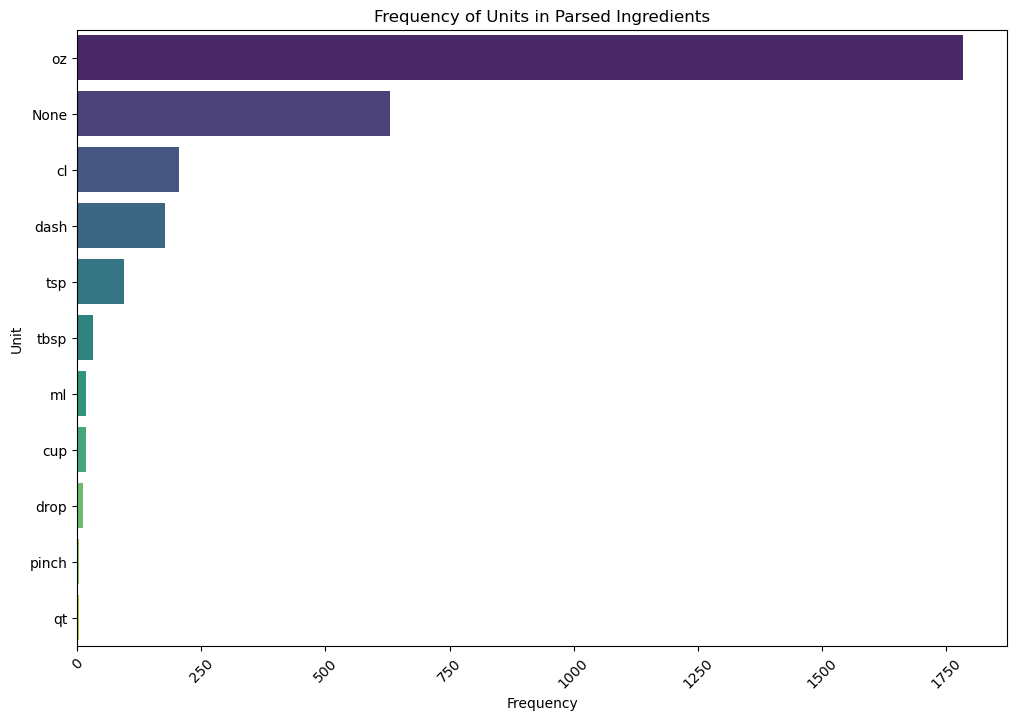

In [59]:
# Count the frequency of each unit, including None (NaN) values
unit_counts = parsed_df['unit'].value_counts(dropna=False)

# replace NaN (None) with a string for visualization purposes:
unit_counts.index = unit_counts.index.fillna('None')

# Create a bar chart
plt.figure(figsize=(12, 8))  
sns.barplot(x=unit_counts.values, y=unit_counts.index, palette="viridis", orient='h')  # Use horizontal bars

plt.title('Frequency of Units in Parsed Ingredients')
plt.ylabel('Unit')  # For horizontal bars, the y-axis now represents units
plt.xlabel('Frequency')
plt.xticks(rotation=45) 

plt.show()

In [60]:
parsed_df.loc[parsed_df['unit']=='cl']

,quantity,unit,ingredient,ingredient_step,recipe_id
52,3,cl,cognac,0,12
53,3,cl,crme de cacao,1,12
54,3,cl,cream,2,12
89,3,cl,gin,0,22
90,3,cl,apricot brandy,1,22
...,...,...,...,...,...
2951,1.5,cl,lime juice,3,664
2961,3,cl,white rum,9,665
2962,1.5,cl,galliano,10,665
2963,1.5,cl,triple sec,11,665


In [61]:
parsed_df.iloc[52]

quantity                3
unit                   cl
ingredient         cognac
ingredient_step         0
recipe_id              12
Name: 52, dtype: object

In [62]:
import numpy as np

In [63]:
# Criteria for filtering: 'unit' is one of 'cl', 'oz', 'qt', and 'quantity' is missing
criteria = (parsed_df['unit'].isin(['cl', 'oz', 'qt'])) & (parsed_df['quantity'].isnull() | (parsed_df['quantity'] == '') | (parsed_df['quantity'] == np.nan))

# Get the indexes that match the criteria
indexes = parsed_df.index[criteria].tolist()

print(indexes)

[216, 219, 1403, 1419, 1420, 2078]


In [64]:
def standardize_units(quantity, unit):
    """
    Converts quantities in 'cl', 'oz', and 'qt' to 'ml'.
    
    Parameters:
    - quantity (str or float or None): The quantity to be converted, which can be in various formats including mixed numbers.
    - unit (str): The unit of the quantity ('cl', 'ml', 'oz', 'qt').
    
    Returns:
    - The standardized quantity in milliliters ('ml') if conversion applies, along with the 'ml' unit.
    """
    # Use the updated function to convert quantity to float, handling mixed numbers, fractions, and decimals
    quantity = convert_mixed_number_to_float(quantity)  # Convert quantity to float
    # rounded conversion factors for clarity  
    if unit == 'cl':
        return quantity * 10, 'ml'
    elif unit == 'oz':
        return quantity * 30, 'ml'  # More accurate conversion factor for ounces to milliliters
    elif unit == 'qt':
        return quantity * 950, 'ml'  # More accurate conversion factor for quarts to milliliters 
    else:
        return quantity, unit


In [65]:
def convert_mixed_number_to_float(quantity):
    """
    Converts quantities represented as mixed numbers (e.g., "1 1/2") into floats.
    This function handles whole numbers, fractions, decimals, mixed numbers,
    and None values.
    
    Parameters:
    - quantity (str or float or None): The quantity to convert.
    
    Returns:
    - The quantity converted to float, or the original quantity if conversion is not possible.
    """
    if quantity is None:
        return 0  # or return None if you prefer to keep None values unchanged

    # Check for mixed numbers (e.g., "1 1/2")
    if ' ' in quantity:
        try:
            whole_number_part, fraction_part = quantity.split(' ')
            whole_number = float(whole_number_part)  # Convert whole number part to float
            # Attempt to convert the fraction part to float
            numerator, denominator = fraction_part.split('/')
            fraction = float(numerator) / float(denominator)
            return whole_number + fraction
        except ValueError:
            pass  # If conversion fails, pass through to try other formats

    try:
        # Attempt to directly convert to float
        return float(quantity)
    except ValueError:
        try:
            # If direct conversion fails, try converting a fraction
            numerator, denominator = quantity.split('/')
            return float(numerator) / float(denominator)
        except ValueError:
            # If conversion still fails, return the quantity as is (which might be a string)
            return quantity

In [66]:
# Apply the conversion to each row in parsed_df
parsed_df[['quantity', 'unit']] = parsed_df.apply(
    lambda row: standardize_units(row['quantity'], str(row['unit']).strip()),
    axis=1, result_type='expand'
)

# Post-Parsing Analysis

In [67]:
parsed_df['unit'].unique()

array(['ml', 'dash', 'drop', 'None', 'cup', 'tsp', 'tbsp', 'pinch'],
      dtype=object)

## Tools to Inspect

### `inspect_row` function

In [68]:
def inspect_row(modified_df, parsed_df, row_index):
    """
    Prints the title, ingredients, and directions of a given row in the modified DataFrame,
    and then prints all corresponding parsed ingredient rows from the parsed DataFrame.
    
    Parameters:
    - modified_df: pandas DataFrame containing the original cocktail data.
    - parsed_df: pandas DataFrame containing the parsed ingredients data.
    - row_index: Integer index of the row to inspect in modified_df and to match in parsed_df.
    """
    # Print details from the modified DataFrame
    print(f"Title: {modified_df.loc[row_index, 'title']}\n")
    print("Ingredients:")
    for ingredient in modified_df.loc[row_index, 'ingredients']:
        print(f"- {ingredient}")
    print("\nDirections:")
    for direction in modified_df.loc[row_index, 'directions']:
        print(f"- {direction}")
    
    # Print corresponding rows from the parsed DataFrame
    print("\nParsed Ingredients:")
    parsed_rows = parsed_df[parsed_df['recipe_id'] == row_index]
    if not parsed_rows.empty:
        print(parsed_rows.to_string(index=False))
    else:
        print("No parsed ingredients found for this recipe.")

In [69]:
parsed_df.iloc[456]

quantity                 30.0
unit                       ml
ingredient         lime juice
ingredient_step             2
recipe_id                 103
Name: 456, dtype: object

In [70]:
inspect_row(modified_df, parsed_df, 103)

Title: Bramble

Ingredients:
- 4 to 5 blackberries
- 1 teaspoon sugar
- 1 ounce lime juice
- 1 1/2 ounces gin
- 1/2 ounce crème de mûre (blackberry liqueur)
- 3 to 4 ounces chilled club soda
- lime wedge

Directions:
- Build over crushed ice, in a rock glass.
- Stir, then Pour blackberry liqueur over the top of the drink in a circular fashion.
- Garnish with a lemon slice, and two blackberries.

Parsed Ingredients:
 quantity unit                    ingredient  ingredient_step  recipe_id
      4.0 None             to 5 blackberries                0        103
      1.0  tsp                         sugar                1        103
     30.0   ml                    lime juice                2        103
     45.0   ml                           gin                3        103
     15.0   ml                 crème de mûre                4        103
      3.0 None to 4 ounces chilled club soda                5        103
      0.0 None                    lime wedge                6        1

### none_rows call

In [71]:
# Filter rows and reset index 
none_rows = parsed_df.loc[parsed_df['quantity'].isnull() | parsed_df['unit'].isnull()].reset_index(drop=True)

# Display the filtered dataframe
none_rows

,quantity,unit,ingredient,ingredient_step,recipe_id


In [72]:
none_rows.loc[none_rows['ingredient_step'] == 0]

,quantity,unit,ingredient,ingredient_step,recipe_id


In [73]:
none_rows.loc[none_rows['ingredient_step'] == 0]

,quantity,unit,ingredient,ingredient_step,recipe_id


### Future tools/calls to look into problems

Can leave this empty for now, just putting in a space here for futureproofing the cleanliness

# Save completed parsed_df

In [74]:
# Save parsed_df to a CSV file
parsed_df.to_csv('clean_df.csv', index=False)